# CoDA × Near/Far (US=6; No‑US at site) — **Self‑contained notebook**

This notebook runs **by itself**:
- Implements a minimal **CoDA** agent (uncertainty-aware split; successor cloning).
- Builds a **stochastic near/far** task where:
  - **US (reward) = 6**.
  - **No‑US at site** = terminal at **2nd 5** on NEAR or **2nd 4** on FAR (the location where reward would have appeared).
- Trains over sessions and reproduces **CSCG‑style correlation panels** plus **Fig. 4i/4j analogues**.

In [1]:

import numpy as np, random
from dataclasses import dataclass, field
from typing import Dict, List, Tuple, Set, Optional
import matplotlib.pyplot as plt
import matplotlib as mpl

random.seed(0); np.random.seed(0)


In [2]:

# Canonical near/far sequences for evaluation (not stochastic)
near_eval = [1,1,1,1,1,1,  2,2,2,2,  1,1,1,  4,6,  1,1,1,  5,5,  1,1,  7,  0,0,0]
far_eval  = [1,1,1,1,1,1,  3,3,3,3,  1,1,1,  4,4,  1,1,1,  5,6,  1,1,  7,  0,0,0]

# Analysis windows (Sun et al. Fig. 4)
preR1_idx = list(range(10,13))  # 10..12
preR2_idx = list(range(15,18))  # 15..17
def block_indices(rows, cols): return [(r,c) for r in rows for c in cols]
offdiag_pairs     = block_indices(preR1_idx, preR2_idx) + block_indices(preR2_idx, preR1_idx)
same_preR1_pairs  = block_indices(preR1_idx, preR1_idx)
same_preR2_pairs  = block_indices(preR2_idx, preR2_idx)


In [3]:

# Base templates
near_base = [1,1,1,1,1,1,  2,2,2,2,  1,1,1,  4,6,  1,1,1,  5,5,  1,1,  7,  0,0,0]
far_base  = [1,1,1,1,1,1,  3,3,3,3,  1,1,1,  4,4,  1,1,1,  5,6,  1,1,  7,  0,0,0]

def find_nth(seq, value, n):
    k=0
    for i,v in enumerate(seq):
        if v==value:
            k+=1
            if k==n: return i
    return None

def truncate_at(seq, idx):
    return seq[:idx+1] if idx is not None else seq

def sample_episode(p4=0.5, p5=0.5, rng=None):
    """
    Returns (states, branch, tag)
    - branch in {'near','far'}
    - tag in {'R@4','NR@2nd-5','R@5','NR@2nd-4'}
    NEAR: if 4→6 happens (prob p4), end at that 6; else end at 2nd 5 (no‑US site).
    FAR : if 5→6 happens (prob p5), end at that 6; else end at 2nd 4 (no‑US site).
    """
    rnd = random.random if rng is None else rng.random
    if rnd() < 0.5:  # NEAR
        seq = near_base.copy()
        i4  = seq.index(4)
        if rnd() < p4:
            term = i4+1; tag = 'R@4'
        else:
            if i4+1 < len(seq) and seq[i4+1]==6: seq.pop(i4+1)
            term = find_nth(seq, 5, 2); tag='NR@2nd-5'
        return truncate_at(seq, term), 'near', tag
    else:            # FAR
        seq = far_base.copy()
        i5  = seq.index(5)
        if rnd() < p5:
            term = i5+1; tag='R@5'
        else:
            if i5+1 < len(seq) and seq[i5+1]==6: seq.pop(i5+1)
            term = find_nth(seq, 4, 2); tag='NR@2nd-4'
        return truncate_at(seq, term), 'far', tag

# Show a few examples
for _ in range(3):
    s, br, tg = sample_episode()
    print(br, tg, ":", s)


far NR@2nd-4 : [1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1, 4, 4]
near R@4 : [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 4, 6]
far R@5 : [1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1, 4, 4, 1, 1, 1, 5, 6]


In [4]:

class NFEnv:
    def __init__(self, n_states: int, reward: int = 6):
        self.num_unique_states = int(n_states)
        self.valid_actions = {s: [0] for s in range(self.num_unique_states)}  # one action
        self.rewarded_terminals   = [int(reward)]
        self.unrewarded_terminals = []    # set per-episode
        self.clone_dict = {}
        self.reverse_clone_dict = {}
    def add_clone_dict(self, clone_id: int, successor: int):
        self.clone_dict[clone_id] = successor
    def add_reverse_clone_dict(self, new_clone: int, successor: int):
        self.reverse_clone_dict[successor] = new_clone


In [5]:

# ===================== Minimal CoDA (uncertainty-aware) =====================

def wilson_lower_bound(phat: float, n: float, confidence: float=0.95) -> float:
    if n <= 0: return 0.0
    z = 1.6448536269514722 if confidence==0.95 else 1.2815515655446004  # ~0.90
    denom = 1.0 + (z*z)/n
    center = phat + (z*z)/(2.0*n)
    adj = z * ((phat*(1.0-phat) + (z*z)/(4.0*n))/n)**0.5
    return (center - adj)/denom

def _ensure_shape_3d(arr: np.ndarray, new_shape: Tuple[int,int,int]) -> np.ndarray:
    if arr is None: return np.zeros(new_shape, dtype=float)
    S_old, A_old, S2_old = arr.shape
    S, A, S2 = new_shape
    out = np.zeros(new_shape, dtype=float)
    out[:S_old, :A_old, :S2_old] = arr
    return out

def normalize_transition_counts(counts: np.ndarray, eps: float=1e-12) -> np.ndarray:
    probs = counts.astype(float, copy=True)
    denom = probs.sum(axis=2, keepdims=True)
    denom[denom < eps] = 1.0
    probs /= denom
    return probs

def get_action_successors_from_counts(counts: np.ndarray, s: int, a: int):
    if counts.size == 0: return []
    succ_mask = counts[s, a] > 0
    return list(np.where(succ_mask)[0])

@dataclass
class CoDAConfig:
    gamma: float = 0.9
    lam: float = 0.8
    theta_split: float = 0.85
    theta_merge: float = 0.5    # merge disabled in this notebook; kept for completeness
    n_threshold: int = 3
    eps: float = 1e-9
    min_presence_episodes: float = 3.0
    min_effective_exposure: float = 8.0
    confidence: float = 0.90
    alpha0: float = 0.25
    beta0: float  = 0.25
    count_decay: float = 1.0
    trace_decay: float = 1.0
    retro_decay: float = 1.0

@dataclass
class CoDAAgent:
    env: NFEnv
    cfg: CoDAConfig = field(default_factory=CoDAConfig)

    n_actions: int = field(init=False)
    n_states: int  = field(init=False)

    transition_counts: np.ndarray = field(init=False)  # [S,A,S']
    transition_probs:  np.ndarray = field(init=False)

    # per-state metadata
    obs_of_state: List[int] = field(init=False)
    state_path: Dict[int, Optional[str]] = field(default_factory=dict, init=False)   # None/'NEAR'/'FAR'
    obs_to_state_ids: Dict[int, List[int]] = field(default_factory=dict, init=False)

    # accumulators
    E_r: np.ndarray = field(init=False)        # [S]
    E_nr: np.ndarray = field(init=False)       # [S]
    exposure: np.ndarray = field(init=False)   # [S]
    presence_episodes: np.ndarray = field(init=False)  # [S]

    # cues/clones
    salient_cues: Set[int] = field(default_factory=set, init=False)
    cue_to_clones: Dict[int, List[int]] = field(default_factory=dict, init=False)
    clone_parent: Dict[int, int] = field(default_factory=dict, init=False)
    created_by_cue: Dict[int, int] = field(default_factory=dict, init=False)

    def __post_init__(self):
        self.n_actions = 1
        self.n_states = self.env.num_unique_states
        self.transition_counts = np.zeros((self.n_states, self.n_actions, self.n_states), dtype=float)
        self.transition_probs  = normalize_transition_counts(self.transition_counts)
        # Base mapping: obs id == state id
        self.obs_of_state = list(range(self.n_states))
        self.obs_to_state_ids = {o: [o] for o in range(self.n_states)}
        self.state_path = {s: None for s in range(self.n_states)}
        # accumulators
        self.E_r = np.zeros((self.n_states,), dtype=float)
        self.E_nr= np.zeros((self.n_states,), dtype=float)
        self.exposure = np.zeros((self.n_states,), dtype=float)
        self.presence_episodes = np.zeros((self.n_states,), dtype=float)

    # growth
    def _maybe_grow(self, needed_state_index: int):
        if needed_state_index < self.n_states: return
        new_n = needed_state_index + 1
        self.transition_counts = _ensure_shape_3d(self.transition_counts, (new_n, self.n_actions, new_n))
        self.transition_probs  = normalize_transition_counts(self.transition_counts)
        # expand per-state arrays
        def grow1d(arr, new_n):
            out = np.zeros((new_n,), dtype=float); out[:arr.shape[0]] = arr; return out
        self.E_r = grow1d(self.E_r, new_n)
        self.E_nr= grow1d(self.E_nr, new_n)
        self.exposure = grow1d(self.exposure, new_n)
        self.presence_episodes = grow1d(self.presence_episodes, new_n)
        # bookkeeping
        for sid in range(self.n_states, new_n):
            self.obs_of_state.append(self.obs_of_state[-1])
            self.state_path[sid] = None
        self.n_states = new_n

    def _select_state_for_obs(self, obs: int, context: Optional[str]) -> int:
        cands = self.obs_to_state_ids.get(obs, [])
        if context is not None:
            for sid in cands:
                if self.state_path.get(sid) == context:
                    return sid
        for sid in cands:
            if self.state_path.get(sid) is None:
                return sid
        return cands[0] if cands else 0

    def run_episode(self, obs_seq: List[int], branch_hint: Optional[str]=None, learn: bool=True) -> List[int]:
        # infer branch if not provided
        context = branch_hint
        if context is None:
            if 2 in obs_seq: context = 'NEAR'
            elif 3 in obs_seq: context = 'FAR'
            else: context = None

        latent_seq = []
        visited = set()
        for obs in obs_seq:
            sid = self._select_state_for_obs(obs, context)
            latent_seq.append(sid); visited.add(sid)

        if not learn:
            return latent_seq

        # transitions
        for t in range(len(latent_seq)-1):
            s, sp = latent_seq[t], latent_seq[t+1]
            self._maybe_grow(max(s, sp))
            self.transition_counts[s, 0, sp] += 1.0

        # presence (per episode)
        for s in visited:
            self.presence_episodes[s] += 1.0

        # identify event at terminal
        event_obs = obs_seq[-1]
        is_reward = (event_obs == 6)
        # eligibility traces back to start
        e = np.zeros((self.n_states,), dtype=float)
        for sid in latent_seq:
            e *= (self.cfg.gamma * self.cfg.lam)
            e[sid] += 1.0
        if is_reward:
            self.E_r += e
        else:
            self.E_nr += e
        self.exposure += e

        # split (no merge during acquisition)
        self._maybe_split(context)
        self.transition_probs = normalize_transition_counts(self.transition_counts)
        return latent_seq

    def prospective(self) -> np.ndarray:
        num = self.E_r.copy()
        den = self.E_r + self.E_nr + self.cfg.eps
        return num/den

    # splitting
    def _maybe_split(self, context_label: Optional[str]):
        P = self.prospective()
        tot = self.E_r + self.E_nr
        for s in range(self.n_states):
            if tot[s] < self.cfg.n_threshold: continue
            if self.presence_episodes[s] < self.cfg.min_presence_episodes: continue
            if self.exposure[s] < self.cfg.min_effective_exposure: continue
            if s in self.salient_cues: continue
            phat = float(P[s])
            lb = wilson_lower_bound(phat, max(tot[s], 1e-9), confidence=self.cfg.confidence)
            if lb > self.cfg.theta_split:
                label = context_label
                clones = self._split_state(s, label)
                if clones:
                    self.salient_cues.add(s)
                    self.cue_to_clones[s] = list(clones)

    def _split_state(self, cue_s: int, path_label: Optional[str]) -> List[int]:
        clones = []
        a=0
        s_primes = get_action_successors_from_counts(self.transition_counts, cue_s, a)
        seen = set()
        for sprime in s_primes:
            if sprime in seen: continue
            seen.add(sprime)
            obs = self.obs_of_state[sprime]
            # look for existing path-specific clone
            existing = None
            for sid in self.obs_to_state_ids.get(obs, []):
                if self.state_path.get(sid) == path_label:
                    existing = sid; break
            if existing is None:
                clone_id = self.n_states
                self._maybe_grow(clone_id)
                self.obs_of_state[clone_id] = obs
                self.obs_to_state_ids.setdefault(obs, []).append(clone_id)
                self.state_path[clone_id] = path_label
                self.env.add_clone_dict(clone_id, successor=sprime)
                self.env.add_reverse_clone_dict(new_clone=clone_id, successor=sprime)
                self.clone_parent[clone_id] = sprime
                self.created_by_cue[clone_id] = cue_s
                clones.append(clone_id)
                # copy outbound transitions
                self.transition_counts[clone_id, :, :] = self.transition_counts[sprime, :, :]
                target = clone_id
            else:
                target = existing
            # rewire cue_s → sprime to cue_s → clone
            cnt = self.transition_counts[cue_s, a, sprime]
            if cnt > 0:
                self.transition_counts[cue_s, a, sprime] = 0.0
                self.transition_counts[cue_s, a, target] += cnt
        return clones


In [6]:

def latent_onehot(agent: CoDAAgent, obs_seq: List[int]) -> np.ndarray:
    lat = agent.run_episode(obs_seq, learn=False)
    S = agent.n_states
    X = np.zeros((len(lat), S), dtype=float)
    for t,sid in enumerate(lat):
        if sid < S: X[t,sid]=1.0
    return X

def near_far_corr(agent: CoDAAgent, near_seq, far_seq) -> np.ndarray:
    A = latent_onehot(agent, near_seq)
    B = latent_onehot(agent, far_seq)
    C = np.zeros((A.shape[0], B.shape[0]))
    for i in range(A.shape[0]):
        for j in range(B.shape[0]):
            a=A[i]; b=B[j]
            a0=a-a.mean(); b0=b-b.mean()
            den = np.linalg.norm(a0)*np.linalg.norm(b0)
            C[i,j] = (a0@b0)/den if den>0 else 0.0
    return C


In [7]:

def train_once(seed=0, sessions=9, trials_per_session=120, p4=0.5, p5=0.5,
               cfg: Optional[CoDAConfig]=None):
    random.seed(seed); np.random.seed(seed)
    n_states = max(max(near_eval), max(far_eval)) + 1
    env = NFEnv(n_states=n_states, reward=6)
    if cfg is None:
        cfg = CoDAConfig()
    agent = CoDAAgent(env, cfg)

    mats_by_session = {}
    THRESH = 0.3
    tt = {'offdiag': None, 'preR2': None, 'preR1': None}

    for session in range(1, sessions+1):
        for _ in range(trials_per_session):
            states, branch, tag = sample_episode(p4=p4, p5=p5)
            # Dynamically set which symbol is no‑US for this episode
            if tag == 'NR@2nd-5':
                env.unrewarded_terminals = [5]
            elif tag == 'NR@2nd-4':
                env.unrewarded_terminals = [4]
            else:
                env.unrewarded_terminals = []

            agent.run_episode(states, branch_hint=('NEAR' if branch=='near' else 'FAR'), learn=True)

        C = near_far_corr(agent, near_eval, far_eval)
        mats_by_session[session] = C.copy()

        def block_mean(C, pairs): 
            return float(np.mean([C[i,j] for (i,j) in pairs])) if pairs else np.nan
        b_off = block_mean(C, offdiag_pairs)
        b_r2  = block_mean(C, same_preR2_pairs)
        b_r1  = block_mean(C, same_preR1_pairs)
        if tt['offdiag'] is None and b_off < THRESH: tt['offdiag'] = session
        if tt['preR2']  is None and b_r2  < THRESH:  tt['preR2']  = session
        if tt['preR1']  is None and b_r1  < THRESH:  tt['preR1']  = session

    return agent, mats_by_session, tt


In [8]:

N_RUNS = 6
SESSIONS = 9
TRIALS_PER_SESSION = 120
P4 = 0.5; P5 = 0.5

all_mats = {s: [] for s in range(1, SESSIONS+1)}
times = []
agents = []

for r in range(N_RUNS):
    agent_r, mats_r, tt_r = train_once(seed=1000+r, sessions=SESSIONS, trials_per_session=TRIALS_PER_SESSION,
                                       p4=P4, p5=P5, cfg=CoDAConfig())
    agents.append(agent_r)
    for s in range(1, SESSIONS+1):
        all_mats[s].append(mats_r[s])
    times.append(tt_r)

agent = agents[0]
check_sessions = [1,3,4,9]
mean_mats = {s: np.mean(np.stack(all_mats[s], axis=0), axis=0) for s in check_sessions}

def norm(x): return (x / SESSIONS) if (x is not None) else np.nan
times_norm = np.array([[norm(tt['offdiag']), norm(tt['preR2']), norm(tt['preR1'])] for tt in times])


/var/folders/s0/k9fg8kp94xl307gydfsd9gf00000gq/T/ipykernel_53250/1770388568.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('magma')


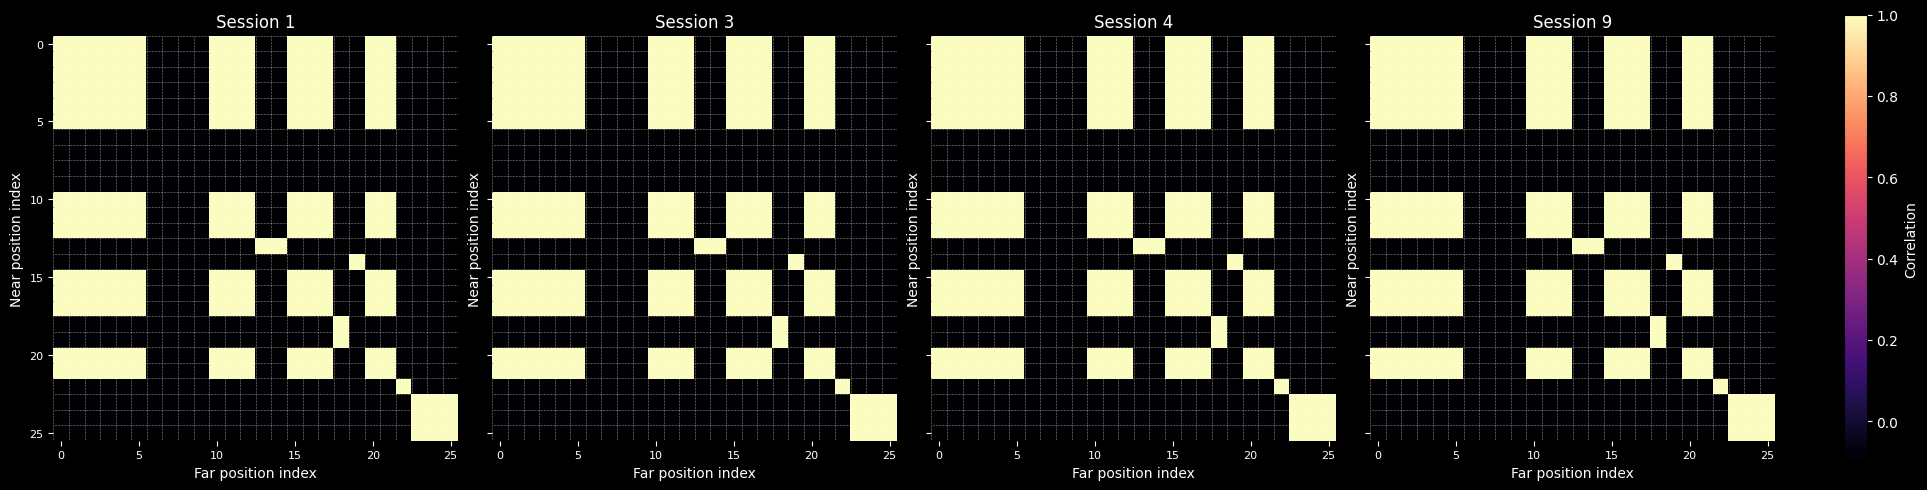

In [9]:

# CSCG-style correlation panels
fig, axes = plt.subplots(1, len(check_sessions), figsize=(4.8 * len(check_sessions), 4.8),
                         constrained_layout=True, sharex=True, sharey=True)
cmap = mpl.cm.get_cmap('magma')
vmin, vmax = -0.1, 1.0
last_im = None
for ax, s in zip(axes, check_sessions):
    M = mean_mats[s]
    last_im = ax.imshow(M, vmin=vmin, vmax=vmax, cmap=cmap,
                        origin='upper', aspect='equal', interpolation='nearest')
    ax.set_title(f"Session {s}", color='white')
    ax.set_xlabel("Far position index", color='white'); ax.set_ylabel("Near position index", color='white')
    ny, nx = M.shape
    ax.set_xticks(np.arange(-0.5, nx, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, ny, 1), minor=True)
    ax.grid(which='minor', color='white', linestyle=':', linewidth=0.4)
    ax.tick_params(colors='white', labelsize=8)
    for spine in ax.spines.values(): spine.set_visible(False)
fig.patch.set_facecolor('black')
for ax in axes: ax.set_facecolor('black')
cbar = fig.colorbar(last_im, ax=axes, fraction=0.046, pad=0.04)
cbar.set_label("Correlation", color='white'); cbar.ax.yaxis.set_tick_params(color='white', labelcolor='white')
plt.show()


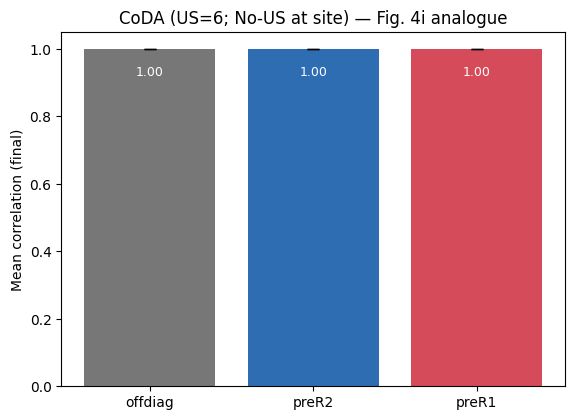

In [10]:

# Fig. 4i analogue: final block means
def block_mean(C, pairs): 
    return float(np.mean([C[i,j] for (i,j) in pairs])) if pairs else np.nan

final_blocks = []
for r in range(N_RUNS):
    C_final = all_mats[SESSIONS][r]
    final_blocks.append([
        block_mean(C_final, offdiag_pairs),
        block_mean(C_final, same_preR2_pairs),
        block_mean(C_final, same_preR1_pairs)
    ])
final_blocks = np.array(final_blocks)
means = np.nanmean(final_blocks, axis=0)
sems  = np.nanstd(final_blocks, axis=0, ddof=1) / np.sqrt(max(1, N_RUNS))

labels = ['offdiag','preR2','preR1']
x = np.arange(len(labels))
fig, ax = plt.subplots(figsize=(6.5,4.6))
bars = ax.bar(x, means, yerr=sems, capsize=4, color=['#777','#2f6db3','#d64b5a'])
ax.set_xticks(x); ax.set_xticklabels(labels)
ax.set_ylim(0, 1.05)
ax.set_ylabel("Mean correlation (final)")
ax.set_title("CoDA (US=6; No‑US at site) — Fig. 4i analogue")
for b, val in zip(bars, means):
    if val > 0.85:
        ax.text(b.get_x()+b.get_width()/2, val-0.05, f"{val:.2f}", ha='center', va='top', color='white', fontsize=9)
    else:
        ax.text(b.get_x()+b.get_width()/2, min(1.02, val+0.05), f"{val:.2f}", ha='center', va='bottom', fontsize=9)
plt.show()


/var/folders/s0/k9fg8kp94xl307gydfsd9gf00000gq/T/ipykernel_53250/3421365402.py:3: RuntimeWarning: Mean of empty slice
  means_t = np.nanmean(times_norm, axis=0)
/opt/anaconda3/envs/coda-minigrid/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


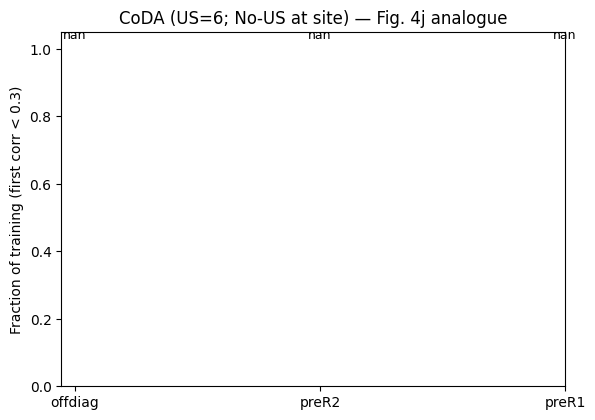

In [11]:

# Fig. 4j analogue: normalized time to first < 0.3
labels = ['offdiag','preR2','preR1']
means_t = np.nanmean(times_norm, axis=0)
sems_t  = np.nanstd(times_norm, axis=0, ddof=1) / np.sqrt(max(1, times_norm.shape[0]))
x = np.arange(len(labels))
fig, ax = plt.subplots(figsize=(6.5,4.6))
bars = ax.bar(x, means_t, yerr=sems_t, capsize=4, color=['#777','#2f6db3','#d64b5a'])
ax.set_xticks(x); ax.set_xticklabels(labels)
ax.set_ylim(0, 1.05)
ax.set_ylabel("Fraction of training (first corr < 0.3)")
ax.set_title("CoDA (US=6; No‑US at site) — Fig. 4j analogue")
for b, val in zip(bars, means_t):
    ax.text(b.get_x()+b.get_width()/2, min(1.02, val+0.05), f"{val:.2f}", ha='center', va='bottom', fontsize=9)
plt.show()
